In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv("mtcars.csv")
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,medium,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,medium,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,low,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,medium,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,high,360.0,175,3.15,3.440,17.02,0,0,3,2


In [3]:
model = bmb.Model("mpg ~ 0 + hp * wt + cyl", data)
idata = model.fit(draws=1000, target_accept=0.95)
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mpg_sigma, cyl, hp:wt, wt, hp]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hp,-0.076,0.031,-0.135,-0.020,0.002,0.001,337.0,496.0,1.00
wt,-5.829,1.649,-8.968,-2.699,0.092,0.065,321.0,372.0,1.01
hp:wt,0.017,0.009,-0.001,0.032,0.000,0.000,337.0,529.0,1.00
cyl[high],40.417,5.987,29.344,51.813,0.323,0.229,343.0,575.0,1.01
cyl[low],43.097,4.558,34.173,50.917,0.257,0.182,313.0,530.0,1.00
cyl[medium],40.913,5.559,30.613,51.296,0.310,0.219,321.0,388.0,1.00
mpg_sigma,2.314,0.343,1.730,2.945,0.015,0.011,527.0,770.0,1.00


In [6]:
def listify(obj):
    """Convert non-list objects to lists."""
    if obj is None:
        return []
    else:
        return obj if isinstance(obj, (list, tuple)) else [obj]

In [7]:
from pandas.api.types import is_categorical_dtype, is_numeric_dtype

def create_cap_data(model, covariates):
    # NOTE: Assumes covariates[0] is numeric
    data = model.data
    covariates = listify(covariates)
    assert len(covariates) in [1, 2]
    main_covariate = covariates[0]
    
    if len(covariates) == 1:
        group_covariate = None
    elif len(covariates) == 2:
        group_covariate = covariates[1]
    else:
        raise ValueError("len(covariates) > 2")
    
    main_covariate_values = np.linspace(
        np.min(data[main_covariate]), 
        np.max(data[main_covariate]), 
        200
    )
    
    if group_covariate:
        group_data = data[group_covariate]
        if is_categorical_dtype(group_data):
            group_covariate_values = np.unique(data[group_covariate])
        elif is_numeric_dtype(group_data):
            groups_n = 5
            group_covariate_values = np.quantile(group_data, np.linspace(0, 1, groups_n))   
                     
        group_covariate_n = len(group_covariate_values)
        main_covariate_n = len(main_covariate_values)
        main_covariate_values = np.tile(main_covariate_values, group_covariate_n)
        group_covariate_values = np.repeat(group_covariate_values, main_covariate_n)
        new_data_dict = {
            main_covariate: main_covariate_values, 
            group_covariate: group_covariate_values
        }
    else:
        new_data_dict = {main_covariate: main_covariate_values}
    
    
    # Construct dictionary of terms that are in the model
    terms = {}
    if model._design.common:
        terms.update(model._design.common.terms)
    
    if model._design.group:
        terms.update(model._design.group.terms)
    
    # Get default values for each variable in the model
    for term in terms.values():
        if hasattr(term, "components"):
            for component in term.components:
                name = component.name
                # For numeric predictors, select the mean.
                if component.kind == "numeric":
                    if name not in new_data_dict:
                        new_data_dict.update({name: np.mean(data[name])})
                # For categoric predictors, select the first level
                elif component.kind == "categoric":
                    if name not in new_data_dict:
                        new_data_dict.update({name: component.levels[0]})
                       
    return pd.DataFrame(new_data_dict)

In [8]:
create_cap_data(model, ["hp", "wt"])

,hp,wt,cyl
0,52.000000,1.513,high
1,53.422111,1.513,high
2,54.844221,1.513,high
3,56.266332,1.513,high
4,57.688442,1.513,high
...,...,...,...
995,329.311558,5.424,high
996,330.733668,5.424,high
997,332.155779,5.424,high
998,333.577889,5.424,high


In [9]:
create_cap_data(model, ["wt", "cyl"])

,wt,cyl,hp
0,1.513000,high,146.6875
1,1.532653,high,146.6875
2,1.552307,high,146.6875
3,1.571960,high,146.6875
4,1.591613,high,146.6875
...,...,...,...
595,5.345387,medium,146.6875
596,5.365040,medium,146.6875
597,5.384693,medium,146.6875
598,5.404347,medium,146.6875


In [10]:
def plot_cap(model, idata, covariates, level=0.95, figsize=(10, 7), ax=None):
    
    covariates = listify(covariates)
    assert len(covariates) in [1, 2]
    
    new_data = create_cap_data(model, covariates)
    new_idata = model.predict(idata, data=new_data, inplace=False)
    
    lb = round((1 - level) / 2, 4)
    ub = 1 - lb
    
    
    y_hat = new_idata.posterior[f"{model.response.name}_mean"]
    y_hat_mean = y_hat.mean(("chain", "draw"))
    y_hat_bounds = y_hat.quantile(q=(lb, ub), dim=("chain", "draw"))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    
    if len(covariates) == 1:
        covariate = covariates[0]
        ax.plot(new_data[covariate], y_hat_mean);
        ax.fill_between(new_data[covariate], y_hat_bounds[0], y_hat_bounds[1], alpha=0.5)
        ax.set(xlabel=covariate, ylabel=model.response.name)
    else:
        covariate, group_name = covariates
        groups = np.unique(new_data[group_name])
        for i, group in enumerate(groups):
            idx = (new_data[group_name] == group).values
            ax.plot(new_data.loc[idx, covariate], y_hat_mean[idx], color=f"C{i}");
            ax.fill_between(
                new_data.loc[idx, covariate], 
                y_hat_bounds[0][idx], 
                y_hat_bounds[1][idx], 
                alpha=0.3,
                color=f"C{i}"
            )
        ax.set(xlabel=covariate, ylabel=model.response.name)
    
    return fig, ax

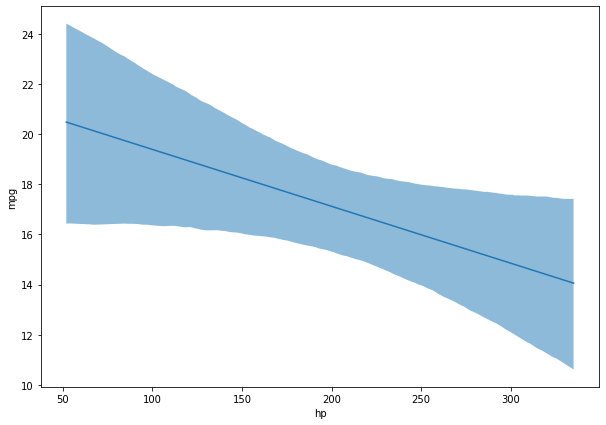

In [11]:
plot_cap(model, idata, "hp");

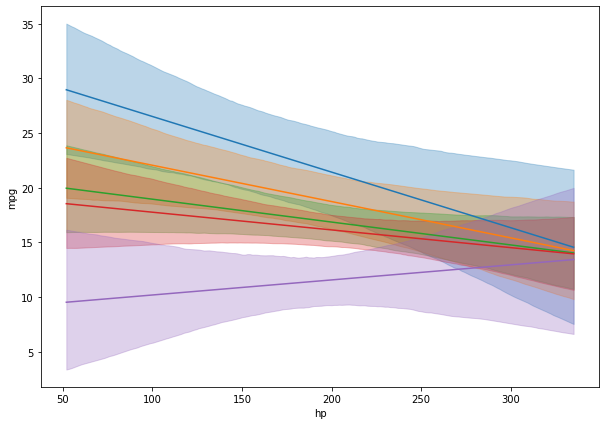

In [12]:
plot_cap(model, idata, ["hp", "wt"]);

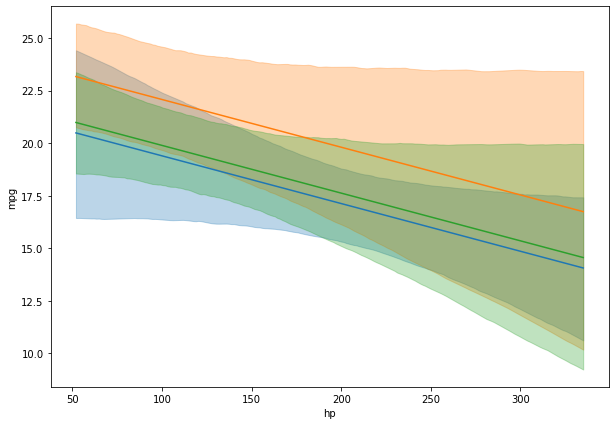

In [13]:
plot_cap(model, idata, ["hp", "cyl"]);